# Загрузка библиотек

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject')

In [ ]:
# для коллаба 
# !pip install torchmetrics

In [2]:
from src.data.preprocessing import create_patches_to_disc
from src.data.dataset import InriaDataset
from src.data.transforms import *
from src.models.unet import UNet
from src.models.losses import DiceBCELoss
from src.train import *
from src.utils.visualize_history import plot_history
from src.utils.visualize_img_gt import visualize_images_and_masks
from src.utils.metrics import SegmentationMetrics
from src.utils.save_checkpoints import save_checkpoint, log_to_csv, load_checkpoint

from configs.base import *

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import json
import os
from glob import glob

from importlib import reload

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка данных

## Комментарий по созданию InriaDataset

Рассматривалось два варианта создания InriaDataset.
1. Без предобработки. Нарезка исходных картинок 5000х5000 "на лету" во время обучения потребует много ресурсов и соответственно много времени на одну эпоху. Но занимает меньше места на диске.
2. С предобработкой. Сохранение патчей 512х512 на диск. Во время обучения обращается напрямую.

Принято решение выбрать второй вариант.

В связи с тем, что объем памяти на диске ограничен, обучать модель будем поэтапно.
1. Загрузили часть обучающих данных.
2. Обучили на них модель.
3. Сохранили веса модели.
4. Удалили обучающие данные.
5. Повторяем пп.1-4, пока не закончаться данные.


На kaggle просто создавался отдельный датасет и подгружался напрямую.

## Предпроцессинг, создание датасета

In [2]:
images_path = os.path.join(PROJECT_PATH, 'train_small_1/images')
gt_path = os.path.join(PROJECT_PATH, 'train_small_1/gt')
images_patches_path = os.path.join(PROJECT_PATH, 'train_small_1/images_patches')
gt_patches_path = os.path.join(PROJECT_PATH, 'train_small_1/gt_patches')

In [ ]:
# Создаем патчи 512х512 из больших картинок 5000х5000
# image_paths, gt_paths = create_patches_to_disc(images_path, gt_path, images_patches_path, gt_patches_path)

# В случае, когда по исходным картинкам патчи уже созданы, просто сохраняем список путей к ним
image_paths = sorted(glob(os.path.join(images_patches_path, "*.tif")))
gt_paths = sorted(glob(os.path.join(gt_patches_path, "*.tif")))

In [36]:
train_img, val_img, train_gt, val_gt = train_test_split(image_paths, gt_paths, test_size=0.2)

In [37]:
train_dataset = InriaDataset(train_img, train_gt, transform=train_transform)
val_dataset = InriaDataset(val_img, val_gt, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

## Создание модели, загрузка весов

In [54]:
model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = DiceBCELoss()
metrics = SegmentationMetrics(device=device)

## Обучение

In [58]:
# Загружаем последнее состояние
model, optimizer, history, best_val_loss, initial_epoch = load_checkpoint(model, optimizer)

Обучение начинается с нуля


In [59]:
try:
  for epoch in range(initial_epoch, initial_epoch + EPOCHS):

    train_loss = train(model, train_loader, optimizer, criterion, device)
    history['train']['loss'].append(train_loss)

    val_loss, val_metrics = validate(model, val_loader, criterion, metrics, device)
    history['val']['loss'].append(val_loss)

    for metric_name in history['val']['metrics'].keys():
        history['val']['metrics'][metric_name].append(val_metrics[metric_name].item())

    print(f'\nEpoch {epoch+1}/{initial_epoch + EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print('Val Metrics:')
    for name, value in val_metrics.items():
        print(f'- {name}: {value:.4f}')


    best_val_loss = save_checkpoint(
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        history=history,
        val_loss=val_loss,
        best_val_loss=best_val_loss
        )


    # Логирование в CSV
    epoch_data = {
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'metrics': {k: v.item() for k, v in val_metrics.items()}
    }
    log_to_csv(epoch_data, history)
except KeyboardInterrupt:
    print("Обучение прервано пользователем")
finally:
    # Всегда сохраняем модель при завершении
    save_checkpoint(
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        history=history,
        val_loss=val_loss,
        best_val_loss=best_val_loss
    )

NameError: name 'val_loss' is not defined

Обучение происходит поэтапно.
В каждом новом этапе подгружаем веса из unet_last.pth
Также сохраняем unet_best.pth

## Визуализация результатов

In [1]:
import torch
from src.models.unet import UNet
p = 'D:/it/geodata_dls_big_files/UNet_best.pth'
model = UNet()
checkpoint = torch.load(p, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Сохранение отдельно весов для инференса на streamlit
torch.save(model.state_dict(), 'D:/it/geodata_dls_big_files/UNet_weights.pth')

In [ ]:
history = checkpoint['history']

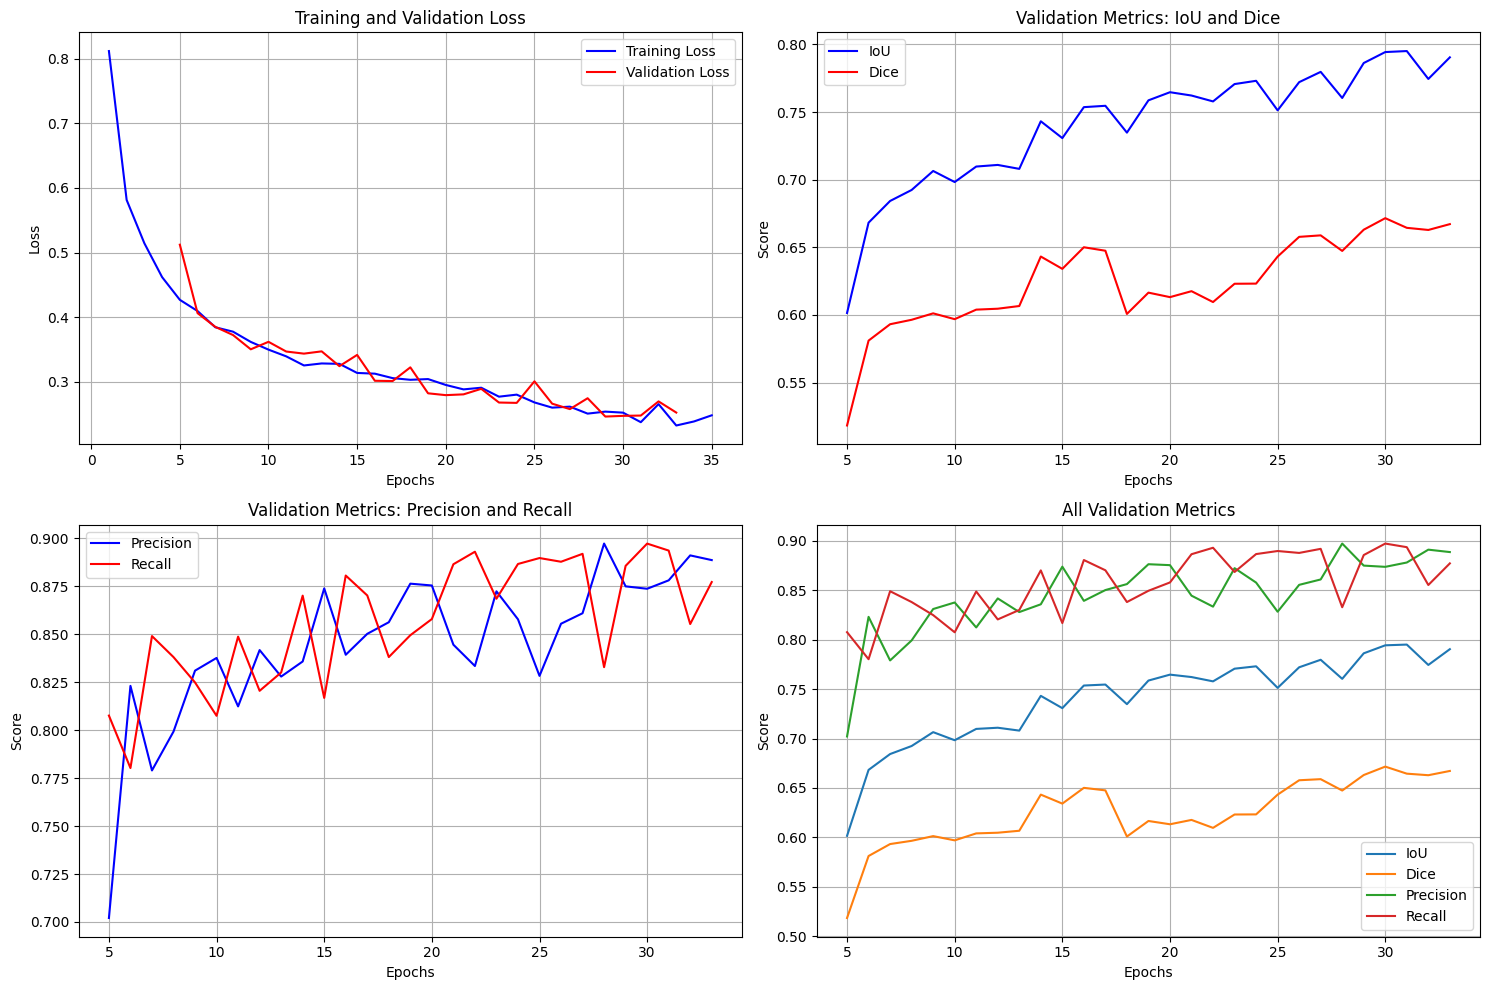

In [14]:
import matplotlib.pyplot as plt

train_loss = history['train']['loss']
val_loss = history['val']['loss']
metrics = history['val']['metrics']


epochs = range(1, len(train_loss) + 1)

# Создаем фигуру с несколькими subplots
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs[4:-2], val_loss[:-2], 'r-', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График метрик IoU и Dice
plt.subplot(2, 2, 2)
plt.plot(epochs[4:-2], metrics['IoU'][:-2], 'b-', label='IoU')
plt.plot(epochs[4:-2], metrics['Dice'][:-2], 'r-', label='Dice')

plt.title('Validation Metrics: IoU and Dice')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# График метрик Precision и Recall
plt.subplot(2, 2, 3)
plt.plot(epochs[4:-2], metrics['Precision'][:-2], 'b-', label='Precision')
plt.plot(epochs[4:-2], metrics['Recall'][:-2], 'r-', label='Recall')

plt.title('Validation Metrics: Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Общий график всех метрик для сравнения
plt.subplot(2, 2, 4)
for metric_name, values in metrics.items():
    plt.plot(epochs[4:-2], values[:-2], label=metric_name)

plt.title('All Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()